# Retina Model

This project is to use relatively easy methods and understandable math to simulate different retinal ganglion cell activities under various receptive field stimulations. Before we get started, here's a brief review of the pathway of light hitting the rods/cones all the way to retinal ganglion cells.

1. Light (photons)
2. Rods and Cones (R/C)
    - (optional) Horizontal Cells (HC)
3. Bipolar Cells (BPC)
    - (optional) Amacrine Cells (AC)
4. Retinal Ganglion Cells (RGC)

As mentioned on the list above, between R/C and BPC, surround R/Cs connect to Horizontal Cells (HC), and between BPC and RGC, some BPCs connect to Amacrine Cells (AC). This model will not be talking about AC roles in RGC activity (e.g., starburst AC's roles in directional specificity). Rather, this model aspires to explain responses of RGCs to static light sources.

## Parameters

We have a lot of parameters to cover, but the gist is:

- The input is either -1 or +1
    - -1 describes the lack of light activating R/Cs
    - +1 describes the presence of light activating R/Cs

- The output will be a gradient between -1 to +1
    - -1 describes maximal hyperpolarization
    - +1 describes maximal depolarization

Since cells connect to each other, synapse (node) calculations are required as well:

- When a synapse is formed, the values add up together, forming a new input to the next cell (node).
- When multiple synapses are connected to the same cell, the input cells are assigned a weight that is the inverse of the number of input cells connected to the new cell.

We assume that at each cell, the cell is excitatory (glutamate releasing) and can pass down the signal. However, there are some exceptions. Not all glutamate-receiving cells are excited - it depends on the receptors. So, we need to add a multiplier to reflect if the signal is inversed or not:

- If the cell is an inhibitory cell (releases GABA, such as HCs), they will have an extra multiplier of -1.
- BPCs also have a multiplier because of different glutamate receptor distribution.
    - ON BPC will have a multiplier of -1 because they have mGluRs.
    - OFF BPC will have a multiplier of +1 because they have iGluRs.

Also, we will not be dealing with color vision. That requires a matrix. So, we will refer R/Cs as rods.

## Setting Up the Simulation

### Establishing the Foundations

Let's set up the basic unit of how many rods or cones are involved. The essence of this simulation is that the receptive field is divided into 2 areas - the center and surround areas. For this simulation, the surround areas will be further divided into 8 subareas - N, NE, E, SE, S, SW, W, and NW (Yes, the actual direction they represent is not an accurate reflection to our visual field, but it works).

Each area will hold the same number of rods.

In [2]:
unit_rod = 5  # each area will have 5 rods
surr_area = 8  # N, NE, E, ...

num_area = surr_area + 1  # calculating the total number of areas

total_rod = unit_rod * num_area
total_rod

45

### Calculating the Weights

As mentioned, the weights will be the inverse of the number of rods connecting to their respective cells. Here, we make an assumption for simplicity. We will assume that each rod contributes equally to the synapse, thus holding the same amount of weight. We will also assume that for each surrounding area, there is an HC that summarizes that area's rod activity. Thus, the more surrounding areas there are, the less weight each HC holds to influence the center cells. Also, we will assume that each HC will connect to all the center rods. As a result, when we are calculating how much activity there is to be passed down to the BPC, we need to finish the HC calculations before passing it down to BPCs.

We will also add the multiplier function here.

In [3]:
flip = -1  # For HCs and ON BPCs due to their inhibitory and mGluR distributions respectively

weight_rod = 1 / unit_rod
weight_HC = flip * 1 / surr_area

print(weight_rod, weight_HC)

0.2 -0.125


### Inputs

Since we have the total number of rods designated to `total_rod`, we need to assign a number (-1 or +1) to each rod. If we have 45 rods, we need 45 inputs. We will be using an array to do this.

- The first `unit_rod` of inputs will correspond to area N
- The second will be area NE
- The third will be area E
- and so on and so forth (SE, S, SW, W, NW), with center being the last `unit_rod` of inputs.

We should also check if our input array is valid - did we add 1 too many inputs or 1 too few?

In [10]:
### PUT THE INPUT ARRAY HERE
### depending on the unit_rod variable, we may need more or less elements in the array
### depending on the surr_area variable, we may need more or less rows in the array
input = [
    -1, -1, -1, -1, -1, #N
    -1, -1, -1, -1, -1, #NE
    -1, -1, -1, -1, -1, #E
    -1, -1, -1, -1, -1, #SE
    -1, -1, -1, -1, -1, #S
    -1, -1, -1, -1, -1, #SW
    -1, -1, -1, -1, -1, #W
    -1, -1, -1, -1, -1, #NW
    1, 1, 1, 1, 1 #Center 
]

# Checking if the input is valid
if len(input) == total_rod:
    print("This input is valid!")
elif len(input) > total_rod:
    print("There might be " + str(len(input) - total_rod) + " extra rod(s) in the input?")
else:
    print("There might be " + str(total_rod - len(input)) + " missing rod(s) in the input?")

This input is valid!


With the input being valid, we need to associate parts of the array to each area. For example, the first `unit_rod` elements will be assigned to the first area, so on and so forth. However, we also need to take into account that we might want to change the number of surrounding areas. In this case, we will make a function that specifically does the chunking, and we iteratively chunk the array into smaller arrays, assigning them numbers.

In [18]:
# The function that chunks big arrays into smaller arrays
# This function is quite general - it takes in the array we need to chunk and how many elements should be in per chunk.
def chunk_array(arr, chunk_size=unit_rod):
    return [arr[i:i + chunk_size] for i in range(0, len(arr), chunk_size)]

# Split into chunks of per unit_rod
area_input = chunk_array(input)

# Assign names using a dictionary
area_dict = {f"area_{i+1}": chunk for i, chunk in enumerate(area_input[:-1])}
area_dict["area_center"] = area_input[-1]  # Special name for the last area, which is the center inputs

# Print the result
for name, chunk in area_dict.items():
    print(f"{name} = {chunk}")


area_1 = [-1, -1, -1, -1, -1]
area_2 = [-1, -1, -1, -1, -1]
area_3 = [-1, -1, -1, -1, -1]
area_4 = [-1, -1, -1, -1, -1]
area_5 = [-1, -1, -1, -1, -1]
area_6 = [-1, -1, -1, -1, -1]
area_7 = [-1, -1, -1, -1, -1]
area_8 = [-1, -1, -1, -1, -1]
area_center = [1, 1, 1, 1, 1]


The printed chunks should have the same value as our inputs. Do double check the following values if errors are spotted.

- `unit_rod`
- `surr_area`
- `input`

If everything looks alright, we can start manipulating the parameters.

### Step 1 - R/C Manipulation

Let's summarize the R/C inputs for each region.

- For the surround area, each area's rods will report to the corresponding HC.
- For the center area, the rods will be manipulated by the surround area HCs, then report to the BPC.

However, before we do all that, we need to flip everything because R/C hyperpolarize in the presence of light. In other words, an input of +1 will yield a -1 result in R/Cs. Likewise, an input of -1 will yield a +1 result in R/Cs.

In [33]:
# Apply transformation of R/C (-1) and weight of R/C
area_rod_dict = {key + "_rod": [x * flip * weight_rod for x in values] for key, values in area_dict.items()}

area_rod_dict

{'area_1_rod': [0.2, 0.2, 0.2, 0.2, 0.2],
 'area_2_rod': [0.2, 0.2, 0.2, 0.2, 0.2],
 'area_3_rod': [0.2, 0.2, 0.2, 0.2, 0.2],
 'area_4_rod': [0.2, 0.2, 0.2, 0.2, 0.2],
 'area_5_rod': [0.2, 0.2, 0.2, 0.2, 0.2],
 'area_6_rod': [0.2, 0.2, 0.2, 0.2, 0.2],
 'area_7_rod': [0.2, 0.2, 0.2, 0.2, 0.2],
 'area_8_rod': [0.2, 0.2, 0.2, 0.2, 0.2],
 'area_center_rod': [-0.2, -0.2, -0.2, -0.2, -0.2]}

### Step 2 - HC Manipulation

Now, here comes the trickier part. We need to sum each surrounding area to form a new dictionary that contains the cell activities of each HC. For example, the HC value for `area_1` will be the sum of the values in the array `area_1_rod`. On top of that, we need to apply the weight of each HC so that we can correctly manipulate each rod in the center area.

Remember, each HC influences every rod in the center area. So each value within `area_center_rod` needs to be manipulated.

In [75]:
# Apply transformation of HC and weight of HC
# Add up to generalize HC influence on each rod in the center
area_HC_dict = {key.replace("_rod", "_HC"): sum(values) * weight_HC for key, values in area_rod_dict.items()}
area_HC_sum = sum(list(area_HC_dict.values())[:-1])

area_HC_dict  # ignore area_center_HC - that is not relevant at all

{'area_1_HC': -0.125,
 'area_2_HC': -0.125,
 'area_3_HC': -0.125,
 'area_4_HC': -0.125,
 'area_5_HC': -0.125,
 'area_6_HC': -0.125,
 'area_7_HC': -0.125,
 'area_8_HC': -0.125,
 'area_center_HC': 0.125}

With the HC influence calculated, we can apply the summated HC influence to each center rod. So, we will call `area_center_rod` and apply the summation onto it. Here, since we already have an `area_center_rod` of `[-1, -1, -1, -1, -1]`, adding another (-1) to the equation will yield `[-2, -2, -2, -2, -2]`. This makes calculations slightly more complicated than we want, so we'll normalize it.

However, there are multiple ways to normalize this. The easy way is to assume linearity, and just apply a `0.5` multiplier to linearly scale it down back to a range of -1 to +1. Alternatively, we can also use `tanh()`, which gives us a non-linear gradient. We will use both just to see.

To use `tanh()`, we will be importing some packages. So, let's import it and test it out.

In [77]:
# Import math
import math
coeff = 1.5  # testing out the coefficient

# Call area_center_rod and apply transformation
area_center_sum = sum((x * flip + area_HC_sum) * weight_rod for x in area_dict["area_center"])

# Normalize the results
area_center_normalized_linear = area_center_sum * 0.5
area_center_normalized_nonlinear = round(math.tanh(coeff * area_center_sum), 2)

print(area_center_normalized_linear, area_center_normalized_nonlinear)

-1.0 -1.0


### Step 3 - RGC Expression

The value we got from the last code block describes the summarized activity of the center R/Cs. Since surround cells synapse with center cells, we only need to see how HCs impact center R/Cs. So, we can take the value and go through BPCs and ultimately RGCs.

The only thing about BPCs is that there are 2 types of BPCs - ON BPCs and OFF BPCs. ON BPCs have a multiplier of (-1) while OFF BPCs don't. We will be exploring both options as well.

In [78]:
ON_RGC_linear = flip * area_center_normalized_linear
OFF_RGC_linear = area_center_normalized_linear

ON_RGC_nonlinear = flip * area_center_normalized_nonlinear
OFF_RGC_nonlinear = area_center_normalized_nonlinear

print(ON_RGC_linear, OFF_RGC_linear, ON_RGC_nonlinear, OFF_RGC_nonlinear)

1.0 -1.0 1.0 -1.0


## Function Retina

In order to make this process able to run through multiple iterations and generate a .csv file for graphing purposes, we will essentially transform the steps above into a single function that takes in the inputs:

- The inputs for R/Cs
- The dimensions for the inputs

It will shoot out the outputs:

- `ON_RGC_linear`
- `OFF_RGC_linear`
- `ON_RGC_nonlinear`
- `OFF_RGC_nonlinear`

In [100]:
import math

def chunk_array(arr, chunk_size):
    """Splits an array into equal-sized chunks."""
    return [arr[i:i + chunk_size] for i in range(0, len(arr), chunk_size)]

def retina(input, unit_rod=5, surr_area=8):
    num_area = surr_area + 1  # Total number of areas
    total_rod = unit_rod * num_area
    coeff = 1.5

    if len(input) != total_rod:
        diff = len(input) - total_rod
        return f"There might be {abs(diff)} {'extra' if diff > 0 else 'missing'} rod(s) in the input?"

    # Split input into chunks
    area_input = chunk_array(input, unit_rod)

    # Assign area names
    area_dict = {f"area_{i+1}": chunk for i, chunk in enumerate(area_input[:-1])}
    area_dict["area_center"] = area_input[-1]

    # Apply transformations
    area_rod_dict = {key + "_rod": [x * flip * weight_rod for x in values] for key, values in area_dict.items()}
    area_HC_dict = {key.replace("_rod", "_HC"): sum(values) * weight_HC for key, values in area_rod_dict.items()}
    area_HC_sum = sum(v for k, v in list(area_HC_dict.items())[:-1])  # Sum all but last

    # Compute center sum with lateral inhibition
    area_center_sum = sum((x * flip + area_HC_sum) * weight_rod for x in area_dict["area_center"])

    # Normalize outputs
    area_center_linear = area_center_sum * 0.5
    area_center_nonlinear = round(math.tanh(coeff * area_center_sum), 2)

    # ON and OFF Retinal Ganglion Cell (RGC) outputs
    ON_RGC_linear = round(flip * area_center_linear, 2)
    OFF_RGC_linear = round(area_center_linear, 2)

    ON_RGC_nonlinear = flip * area_center_nonlinear
    OFF_RGC_nonlinear = area_center_nonlinear

    result_array = [ON_RGC_linear, OFF_RGC_linear, ON_RGC_nonlinear, OFF_RGC_nonlinear]

    return result_array


With the function realized, we can start messing with inputs. Let's first check if this function can run with our example input. If it can, let's simulate the 4 basic scenarios - center response, surround response, both response, and neither response. For those 4 scenarios, the results are as follows.

**1. Center Response**

In this case, the center is lit while the surround is dark.
- On-center RGCs should have +1
- Off-center RGCs should have -1

**2. Surround Response**

The surround is lit while the center is dark.
- On-center RGCs should have -1
- Off-center RGCs should have +1

**3. Both Response**

Both the center and surround are lit.
- On-center RGCs should have 0
- Off-center RGCs should have 0

**4. Neither Response**

Neither the center nor surround is lit.
- On-center RGCs should have 0
- Off-center RGCs should have 0


In [102]:
center_response = [
    -1, -1, -1, -1, -1, #N
    -1, -1, -1, -1, -1, #NE
    -1, -1, -1, -1, -1, #E
    -1, -1, -1, -1, -1, #SE
    -1, -1, -1, -1, -1, #S
    -1, -1, -1, -1, -1, #SW
    -1, -1, -1, -1, -1, #W
    -1, -1, -1, -1, -1, #NW
    1, 1, 1, 1, 1 #Center 
]

surround_response = [
    1, 1, 1, 1, 1, #N
    1, 1, 1, 1, 1, #NE
    1, 1, 1, 1, 1, #E
    1, 1, 1, 1, 1, #SE
    1, 1, 1, 1, 1, #S
    1, 1, 1, 1, 1, #SW
    1, 1, 1, 1, 1, #W
    1, 1, 1, 1, 1, #NW
    -1, -1, -1, -1, -1 #Center 
]

both_response = [
    1, 1, 1, 1, 1, #N
    1, 1, 1, 1, 1, #NE
    1, 1, 1, 1, 1, #E
    1, 1, 1, 1, 1, #SE
    1, 1, 1, 1, 1, #S
    1, 1, 1, 1, 1, #SW
    1, 1, 1, 1, 1, #W
    1, 1, 1, 1, 1, #NW
    1, 1, 1, 1, 1 #Center 
]

neither_response = [
    -1, -1, -1, -1, -1, #N
    -1, -1, -1, -1, -1, #NE
    -1, -1, -1, -1, -1, #E
    -1, -1, -1, -1, -1, #SE
    -1, -1, -1, -1, -1, #S
    -1, -1, -1, -1, -1, #SW
    -1, -1, -1, -1, -1, #W
    -1, -1, -1, -1, -1, #NW
    -1, -1, -1, -1, -1 #Center 
]

print(retina(center_response),
    retina(surround_response),
    retina(both_response),
    retina(neither_response))

[1.0, -1.0, 1.0, -1.0] [-1.0, 1.0, -1.0, 1.0] [-0.0, 0.0, -0.0, 0.0] [-0.0, 0.0, -0.0, 0.0]


## Collecting and Analyzing Data

With the function complete, we can start altering our inputs and run through the program to visualize data. For example, this section will focus on altering the center response in the following way:

- Each iteration, 1 more surround rod switches from -1 to +1.

This simulates the surround getting more and more light. We will observe how that affects the response from on- and off-center RGCs.

### Obtaining a .csv File

Before the data is being collected, we need a `.csv` file to store the data.

In [ ]:
import csv

# Define the CSV filename
csv_filename = "retina_results.csv"

# Open the CSV file in append mode ('a') and write results
with open(csv_filename, mode='a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["ON_RGC_linear", "OFF_RGC_linear", "ON_RGC_nonlinear", "OFF_RGC_nonlinear"])



### Altering Inputs

With the `.csv` file in place, we can start altering our inputs. Preferably, we can dynamically alter our inputs. The altering method we are using is to replace the -1 with +1 one by one. For example, `[-1, -1, -1, -1, -1]` becomes `[1, -1, -1, -1, -1]` then `[1, 1, -1, -1, -1]` then `[1, 1, 1, -1, -1]` then `[1, 1, 1, 1, -1]` and finally `[1, 1, 1, 1, 1]`.

In [114]:
def generate_array(size=unit_rod*surr_area, unit_rod=5, fill_value=-1):
    # Generates a list of lists with an increasing number of 1s per row, ensuring the last `unit_rod` elements are always 1.
    return [[1] * i + [fill_value] * (size - i) + [1] * unit_rod for i in range(size + 1)]

# Generate the array
input_array = generate_array()

# Print the result nicely
for row in input_array:
    print(row)  # There might be a lot of inputs depending on your parameters


[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1]
[1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1]
[1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1]
[1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1

### Experiment

Now comes the part where we run through the altered inputs and obtain results in the `.csv` file. Ideally, `retina_results.csv` should be nicely filled up with data.

In [118]:
csv_filename = "retina_results.csv"

with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)

    # Write header only if file is empty
    if file.tell() == 0:
        writer.writerow(["ON_RGC_linear", "OFF_RGC_linear", "ON_RGC_nonlinear", "OFF_RGC_nonlinear"])

    # Iterate over each input array and save results
    for element in input_array:
        results = retina(element)  # Get the tuple of 4 values
        writer.writerow(results)  # Write the results to CSV

With the new `.csv` file, we can plot a graph that takes in the index as the x-variable and the magical number as the y-variable. Honestly, I don't know what to expect - linear RGCs will respond linearly to linear changes in light, while nonlinear RGCs will respond nonlinearly to linear changes in light.

Regardless, we will be using `matplotlib` for graphing and `numpy` and `pandas` for data manipulations.

C:\Users\YF Wu\AppData\Local\Temp\ipykernel_18112\2498224812.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


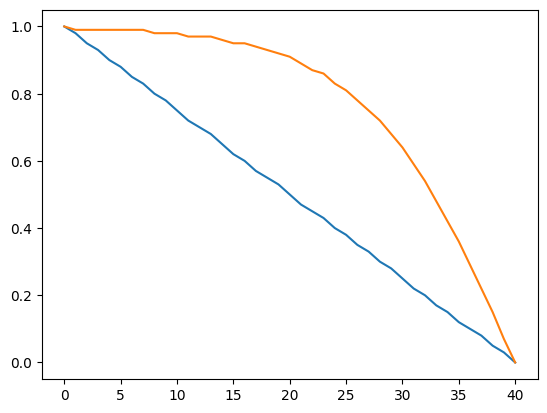

In [121]:
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import numpy as np
import pandas as pd

df = pd.read_csv("retina_results.csv")

fig, ax = plt.subplots()
ax.plot(df["ON_RGC_linear"])
ax.plot(df["ON_RGC_nonlinear"])
fig.show()

We can simply flip our inputs such that we start from surround response and turn off each rod during each iteration. Quite predictably, it will have vertical symmetry with the graph above, that is, flipped along the x-axis.

With the model working hopefully as intended, we can bring this to the webpage.

## Debugging

So, after finishing this, there are some debugging since I decided to change some parameters, and that led to some issues. I fixed the issues at the JavaScript end, but because this page is used as a place to play around and document my thought process, the code in this file is not fixed regularly.

The plan is to change the `retina` function so that it reflects the updated JavaScript code. However, the thought processes will not be updated accordingly.